# Introduction

This is a supporting notebook that contains more technical information about our work and answers some questions about the data, methods, and technical aspects of our work. Here we want to explain how most of our results, such as visualizations, came to life, what approaches we took and why.

**Note:** This notebook contains some examples of code that we found most interesting to show. We have over 10 notebooks in total, so compiling all the code here would be very messy and unreadable. These approaches are applied for all the data we had in almost the same fashion.

All the functional notebooks with full code can be found [here](https://github.com/MarkTselikov/social_data_viz/tree/main/functional_notebooks).

In [5]:
# importing the libraries and setting up the environment 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

%matplotlib inline 

### Motivation

The motivation behind this project is to try to see how we can measure happiness and analyse some already existing reports and metrics. 

One of the most famous reports about happines is the *World Happiness Report* (WHR), which is published annually since 2012. The idea was to see how other external factors, like unemployment, crime rate, and so on, correlate with the happiness score in the report, conclude which factors correlate with the happiness, and evaluate if the report is accurate and if there is anything overlooked.
We used the data from the report as our main dataset, however, we had to use the data from 2014 since the previous report didn't have official data published. 

Of course, World Happiness Report is not the only report that tries to reflect the wellbeing of people, and it is often critisized for being inaccurate and biased towards GDP and economical situation in the country. Another dataset that we used and tested was the *Legatum Prosperity Index*, which is upposed to be much broader view on the situation in every country, and we compared it with the WHR data. 

Apart from the main two datasets, we used a number of other datasets with factors, such as income inequality, crime rate, suicide rate, etc. Our goal was to see how the features from these datasets correlate with the happiness and each other, and in case if they are not, we can evaluate the scoring system of the WHR.

### End goal

Our final version of the project was planned to in a format of an article with interactive and static plots, where we would go over a number of different factors one-by-one, analyze the situation, and present our conclusions and theories. We drew a lot of inspiration from articles from *Our World In Data*, like [this one](https://ourworldindata.org/deforestation). We really liked the format of posing the question, analyzing the data and discussing it, while also presenting it on an interactive plot. 

# Data processing 

### ISO country codes

Since we used the choropleth plots with geographical data, we had to unify the datasets to have the same country codes to be able to merge them and display the data on the plots. We used the [ISO 3166-1 alpha-3](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) format of the country codes. To make the process easier, we used *geopandas* library to get the world map that contains the figures of the countries with their ISO codes and to be able to merge the data with it. To get the ISO country codes for our data, we used the *pycountry* library that allowed us to get the codes by the country name.   

The biggest challenge here was the fact that every dataset is a bit different, and sometimes the same countries have different names (United States of America and USA). In that case, we had to unify the names, and in some cases if *pycountry* couldn't recognize the names of some countries, which required us to manually search for their ISO codes and insert them into the dataset.

In [37]:
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
            CODE.append(code)
        except:
            CODE.append('Unknown')
    return CODE

data.replace(['Russia'], 'Russian Federation', inplace=True)
data['Country Code'] = alpha3code(data['Country'].str.strip())


In [52]:
data.loc[data['Country'] == 'Venezuela', 'Country Code'] = 'VEN'
data.loc[data['Country'] == 'Czech Republic', 'Country Code'] = 'CZE'
data.loc[data['Country'] == 'Taiwan', 'Country Code'] = 'TWN'
data.loc[data['Country'] == 'Taiwan Province of China', 'Country Code'] = 'TWN'
data.loc[data['Country'] == 'South Korea', 'Country Code'] = 'KOR'

In [50]:
data.head()

,Country,Happiness Rank,Happiness Score,Economy (GDP per Capita),Health (Life Expectancy),Freedom,Generosity,Perceptions of corruption,Year,Country Code
0,Switzerland,1,7.587,1.39651,0.94143,0.66557,0.29678,0.41978,2014,CHE
1,Iceland,2,7.561,1.30232,0.94784,0.62877,0.43630,0.14145,2014,ISL
2,Denmark,3,7.527,1.32548,0.87464,0.64938,0.34139,0.48357,2014,DNK
3,Norway,4,7.522,1.45900,0.88521,0.66973,0.34699,0.36503,2014,NOR
4,Canada,5,7.427,1.32629,0.90563,0.63297,0.45811,0.32957,2014,CAN


### "Melting" and unfolding the datasets

Many datasets that we've encountered are shaped in the pivot table form, where the values for a certain metric are filled in for every year in a single row, and every year of the dataset is displayed as a column. To be able to work with such data, we had to "melt" the data using *pandas* to flatten the years into a single column. 

In some cases, there was an opposite problem where metrics were compressed into a single column, and it would be much more convenient to have every separate metric as a separate column.

In [6]:
# Data before melting and cleaning
data = pd.read_excel('data/Legatum_Prosperity_Index_Full_2020_Data_Set.xlsx', engine='openpyxl')
data.head(3)

,area_name,area_code,area_group,rank_2007,rank_2008,rank_2009,rank_2010,rank_2011,rank_2012,rank_2013,...,score_2011,score_2012,score_2013,score_2014,score_2015,score_2016,score_2017,score_2018,score_2019,score_2020
0,Afghanistan,AFG,Asia-Pacific,163,163,162,161,162,161,160,...,34.018804,33.529762,34.848416,35.455467,33.878693,34.122529,34.704901,33.234143,33.607822,34.350055
1,Albania,ALB,Eastern Europe,74,75,76,67,66,65,66,...,57.100940,57.345438,57.155699,57.095382,57.409473,57.699371,57.855046,59.182053,60.132551,59.573636
2,Algeria,DZA,Middle East and North Africa,107,109,107,107,103,110,111,...,50.207155,48.905687,48.401319,49.657271,49.944818,50.026566,49.876850,50.919671,51.913637,51.869120


In [7]:
# Cleaning and processing

def clean_year(row):
    return row.split('_')[1]
    
data = pd.melt(data, id_vars=['area_name', 'area_code', 'area_group'], value_vars=[ 'score_2007', 'score_2008', 'score_2009',
       'score_2010', 'score_2011', 'score_2012', 'score_2013', 'score_2014',
       'score_2015', 'score_2016', 'score_2017', 'score_2018', 'score_2019',
       'score_2020'])

data['variable'] = data['variable'].apply(clean_year)
data.columns = ['Country', 'Country Code', 'Area Group', 'Year', 'Score']
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')

# Data after cleaning and melting
data.head(3)

,Country,Country Code,Area Group,Year,Score
0,Afghanistan,AFG,Asia-Pacific,2007,33.691287
1,Albania,ALB,Eastern Europe,2007,54.876495
2,Algeria,DZA,Middle East and North Africa,2007,48.828327


# EDA

Here we will do a short Exploratory Data Analysis on the WHR data. This is an example of how we did EDA for most of the datasets we've worked with, so for the sake of saving space we will be focusing only on WHR data.

In [32]:
world_happ_data = pd.read_csv('data/whr_data.csv', )
world_happ_data.drop('Unnamed: 0', axis=1, inplace=True)
world_happ_data.head()

,Country,Happiness Rank,Happiness Score,Economy (GDP per Capita),Health (Life Expectancy),Freedom,Generosity,Perceptions of corruption,Year,Country Code
0,Switzerland,1,7.587,1.39651,0.94143,0.66557,0.29678,0.41978,2014,CHE
1,Iceland,2,7.561,1.30232,0.94784,0.62877,0.43630,0.14145,2014,ISL
2,Denmark,3,7.527,1.32548,0.87464,0.64938,0.34139,0.48357,2014,DNK
3,Norway,4,7.522,1.45900,0.88521,0.66973,0.34699,0.36503,2014,NOR
4,Canada,5,7.427,1.32629,0.90563,0.63297,0.45811,0.32957,2014,CAN


In [32]:
fig = plt.figure(figsize=(14,8))
col = list(world_happ_data.columns[:7])
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.title(col[i])
    sns.boxplot(data = world_happ_data[[col[i]]], palette="Set2")col = list(world_happ_data.columns[1:7])
for c in col:
    print(c)
    print('----'*3)
    ma = world_happ_data[c].max()
    print('Max score ',ma)
    print(world_happ_data.loc[world_happ_data[c] == ma, 'Country'])
    print()
    mi = world_happ_data[c].min()
    print('Min score ',mi)
    print(world_happ_data.loc[world_happ_data[c] == mi, 'Country'])
    print('\n')
    

Happiness Score
------------
Max score  7.809
782    Finland
Name: Country, dtype: object

Min score  2.567
934    Afghanistan
Name: Country, dtype: object


Economy (GDP per Capita)
------------
Max score  2.096
489    United Arab Emirates
Name: Country, dtype: object

Min score  0.0153
156    Burundi
Name: Country, dtype: object


Health (Life Expectancy)
------------
Max score  1.141
659    Singapore
Name: Country, dtype: object

Min score  0.005564753897488121
420    Sierra Leone
Name: Country, dtype: object


Freedom
------------
Max score  0.7240000000000001
513    Uzbekistan
Name: Country, dtype: object

Min score  0.00589
298    Angola
Name: Country, dtype: object


Generosity
------------
Max score  0.8380751609802249
428    Myanmar
Name: Country, dtype: object

Min score  0.00199
63    Russian Federation
Name: Country, dtype: object


Perceptions of corruption
------------
Max score  0.55191
153    Rwanda
Name: Country, dtype: object

Min score  0.001
521                   Ro

In [ ]:
col = list(world_happ_data.columns[:7])

fig = make_subplots(rows=3, cols=2,
                   subplot_titles = list(world_happ_data.iloc[:,1:7].columns))

i = 1
j = 1
for k in range(1,7):
    dfo = world_happ_data[col[k]]
    fig.append_trace(go.Histogram(x = dfo, name = 'All'+': '+col[k],
                                      opacity = 0.4,
                                     marker_color = 'rgb(179,226,205)',
                                 legendgroup = 'All'),
                         row = i, col = j)
    for cont in set(world_happ_data.continent):
        fig.append_trace(go.Histogram(x = dfo[world_happ_data.continent == cont], name = cont+': '+col[k],
                                      opacity = 0.75,
                                      legendgroup = cont,
                                     marker_color = cont_color[cont]),
                         row = i, col = j)
    #showleg = False
    if i == 3:
        i = 1
        j += 1
    else:
        i += 1
fig.layout.update(go.Layout(barmode = 'overlay',))
#py.plot(fig,filename = 'continent_hist', auto_open=True)

fig.show()


![Hist](img/hist.png)

In [35]:
for i in range(1,7):
    print(col[i])
    Q1 = world_happ_data[col[i]].quantile(0.25)
    Q3 = world_happ_data[col[i]].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (world_happ_data[col[i]] >= Q1) & (world_happ_data[col[i]] <= Q3)
    print('Percentage that doesn\'t fall within Q1 and Q3: ',round(sum(filter)/len(world_happ_data)*100,2),'%')
    print()

Happiness Score
Percentage that doesn't fall within Q1 and Q3:  50.05 %

Economy (GDP per Capita)
Percentage that doesn't fall within Q1 and Q3:  49.62 %

Health (Life Expectancy)
Percentage that doesn't fall within Q1 and Q3:  50.05 %

Freedom
Percentage that doesn't fall within Q1 and Q3:  49.62 %

Generosity
Percentage that doesn't fall within Q1 and Q3:  49.62 %

Perceptions of corruption
Percentage that doesn't fall within Q1 and Q3:  50.16 %



# Data Analysis

The general structure of the data analysis that we performed was to take each secondary dataset and see how it correlates with the happiness scores. The goal of that was to see which other factors might contribute to or correlate with the happiness, and to explore if some of the factors might have been overlooked by the report and the scoring methodology. 

As example, we have a code to analyze the correlation between features of the WHR dataset for every continent, as well as their distribution in every continent using a boxplot.

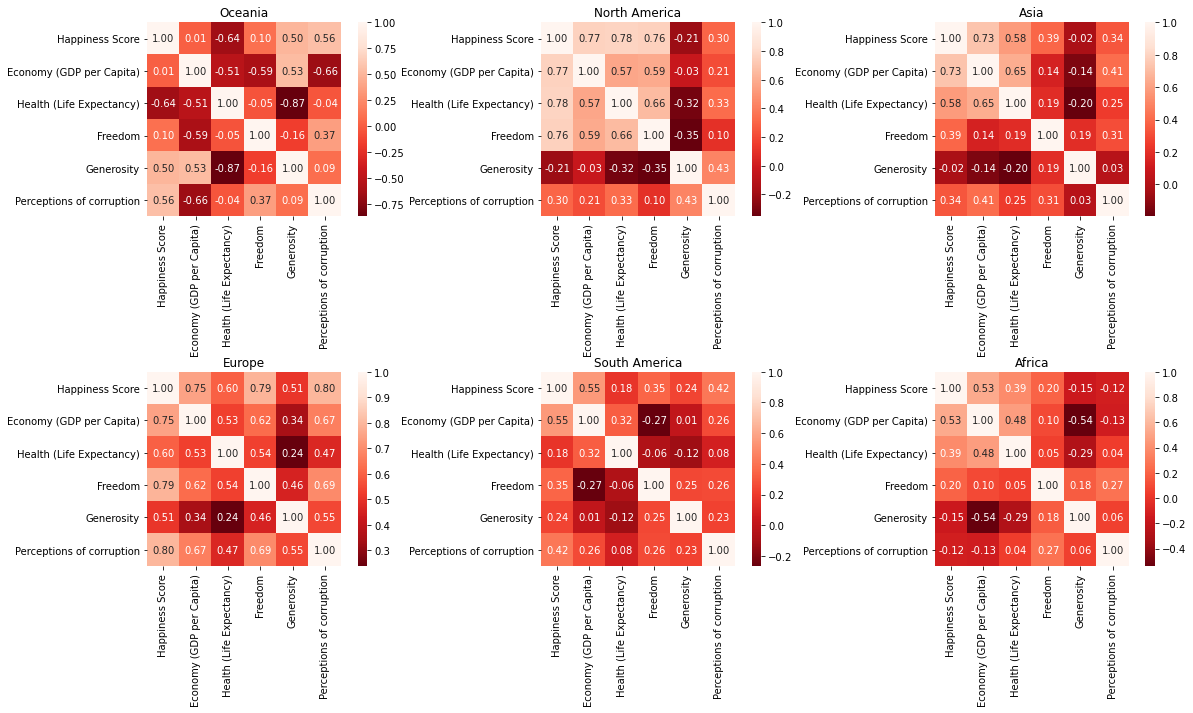

In [36]:
Continents = {'AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'}

fig = plt.figure(figsize=(20,10))
df1 = world_happ_data[list(world_happ_data.columns[1:7])+['continent']]
cont = list(set(df1.continent))
for c in range(1, len(cont)+1):
    con = cont[c-1]
    df2 = df1[df1.continent == con]
    df2corr = df2.drop(['continent'], axis = 1).corr()
    plt.subplot(2,3,c)
    plt.title(Continents[con])
    sns.heatmap(df2corr, annot=True, fmt='.2f', square=True, cmap = 'Reds_r')

plt.subplots_adjust(hspace = 0.8) 
plt.show()

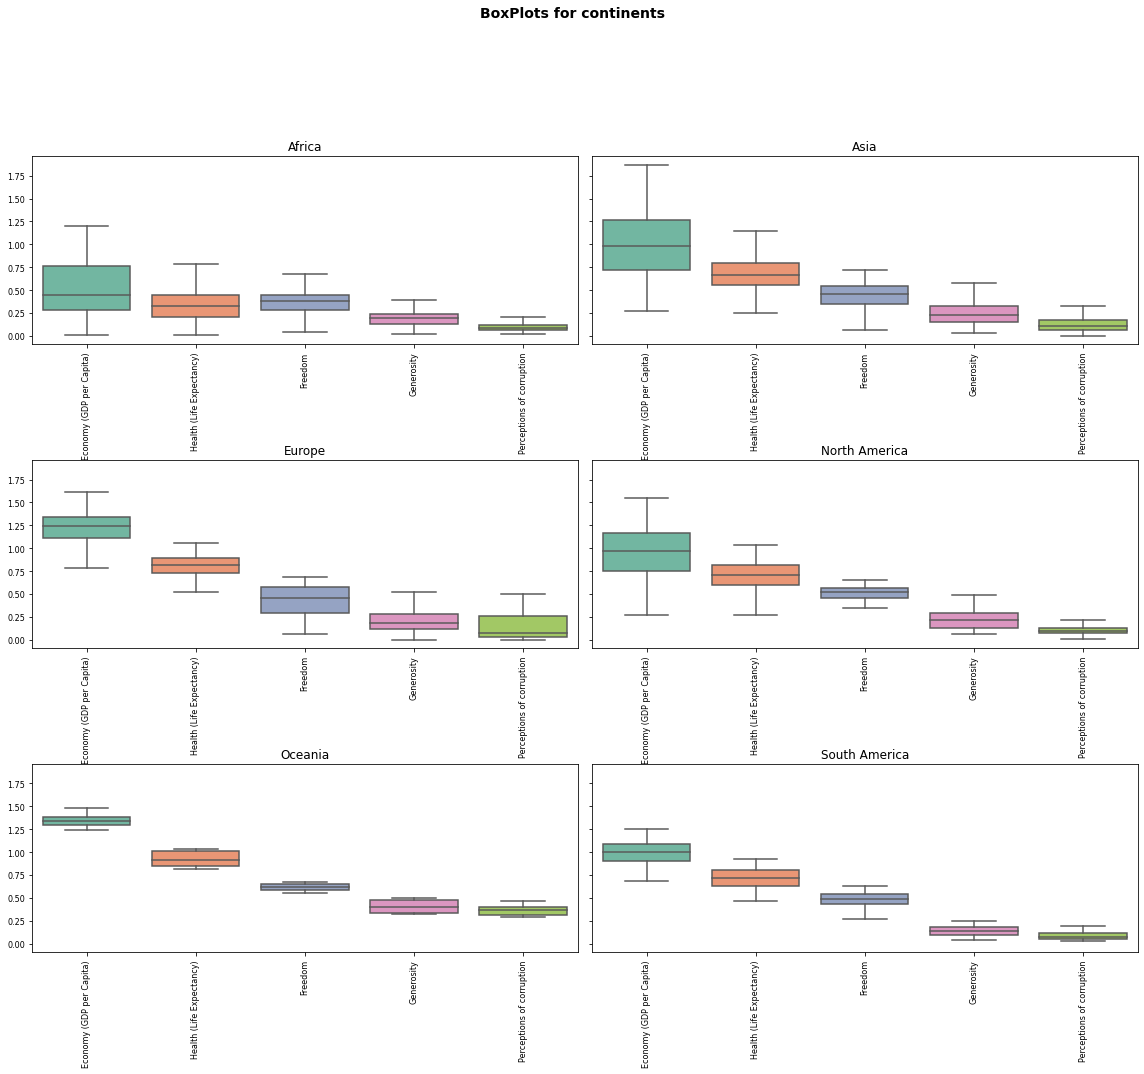

In [37]:
import math
num_cols = 2
num_rows = int(math.ceil(len(Continents) / float(num_cols)))
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 16), sharey = True)
#x_var = df_orig['hra']
var = list(world_happ_data.columns[2:7])
df1 = world_happ_data[var+['continent']]

for idx, ax in enumerate(axes.flat):
    con = list(Continents.keys())[idx]
    d = df1[df1.continent == con]
    title_str = ''
    sns.boxplot(data = d, ax=ax, palette="Set2", showfliers=False)
    ax.set_title(list(Continents.values())[idx] + title_str)
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
fig.suptitle("BoxPlots for continents", x=0.5, y=0.93, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.8)

# Feature Importance and ML model

To compare the World Happiness Report and the Legatum Prosperity Index data, we used a machine learning model that we trained and extracted the feature importance. The training data consisted of the datasets that we analized together with both WHR data and Legatum data. The model of our choice was *Random Forest Classifier*, which is a decent machine learning model that is easily interpretable.

This process involved *Grid Search* 5 KFolds to pick the best parameters for the model. We decided to leave the features that come with the datasets apart from the score in the training data, which of course cause a certain degree of bias, but our goal was to see if the external factors can influence the prediction of the score and how the ML model would react to them. In addition, we transformed the continuous score variables in both datasets into 4 categorical ones, which followed the logic of *very low, low, high, very high* scores for simplicity. Then we trained the models for both datasets and extracted the feature importance.



In [91]:
def get_cat_happiness(row):
    if row <= 3.5:
        return 0
    elif row > 3.5 and row <= 5:
        return 1
    elif row > 5 and row <= 6.5:
        return 2
    else:
        return 3

In [92]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils

data.drop('Happiness Rank', axis=1, inplace=True)
data.drop('Country Name', axis=1, inplace=True)
data.drop('Country_y', axis=1, inplace=True)
data.drop('Country Code', axis=1, inplace=True)
data['Happiness'] = data['Happiness Score'].apply(get_cat_happiness)
data.drop('Happiness Score', inplace=True, axis=1)

data.dropna(inplace=True)

X = data.drop('Happiness', axis=1)
y = data['Happiness']

lab_enc = preprocessing.LabelEncoder()
y = lab_enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

cv_kfold = KFold(n_splits=5)

# parameter combinations that will be tested for a Random Forest model
param_grid = {
    'n_estimators': [5, 10, 25, 50, 100, 200],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_depth': [3, 5, 10, 20]
}

model = RandomForestClassifier()

grid_cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv_kfold)
grid_cv.fit(X_train, y_train)
grid_cv.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=10)

In [98]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.8418181818181818
{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}


In [99]:
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=10)
model.fit(X_train, y_train)

prediction = model.predict(X_test)
print('Accuracy on the training data: {}'.format(accuracy_score(model.predict(X_train), y_train)))
print('Accuracy on the testing data: {}'.format(accuracy_score(prediction, y_test)))

Accuracy on the training data: 0.8235294117647058
Accuracy on the testing data: 0.6538461538461539


C:\Users\markt\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\markt\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\markt\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


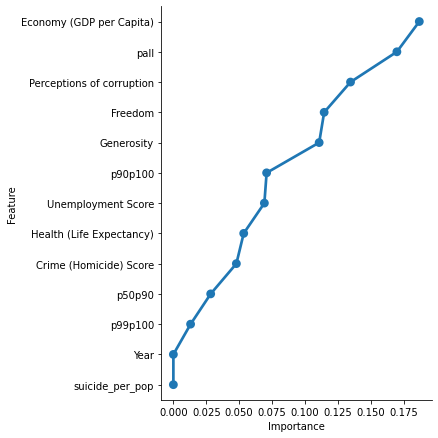

In [100]:
feature_values = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})
feature_values = feature_values.sort_values('Importance', ascending=False)

sns.factorplot('Importance', 'Feature', data=feature_values, size=6)

# Genre

Our report includes a lot of data from different sources that we compare and try to draw conclusions for every element separately and sometimes together. As result, we have many complex plots and lots of results to be discussed. That means that the structure of our report needs to be granulated to be able to highlight separate conclusions and so the report is not a mess, but at the same time we need to connect the sections together in one narrative so they are not disconnected. 

That is why we chose the **Magazine Style** of reporting according to the *Segal and Heer* classification. It gives us more space and freedom and allows us to keep everything tied together. As mentioned before, our main source of inspiration were articles from [Our World in Data](https://ourworldindata.org/) that have similar approach. 

With ordering: 
* Linear 
The story line is linear, where the user is brought along the different subsections. We used Medium.com which is one of the largest blogging websites. The user scrolls to view the different attributes questioned in the report. 


With interactivity: 
* Hover highlighting / Details 
* Stimulating default views 
* Filtering/ Selection /Search 
Plotly's built in functionality allows us to hover details on a specific point, filter the attributes and stimulate the default overall view. The user feels comfortable and is able to zoom in and out between different points. 
For plots like sunburst, it allows the users to get detailed averages in the attributes listed. The default views were carefully selected to ensure that only valuable information was displayed. 

With messaging: 
* Captions
* Introductory text 
* Summary 
* Comment repetition 
Using Medium's built in functionality, captions, introductory text, summary and comment repetition was done. 
Comment repetition was highlighted.Captions were provided when neccessary if it was not included in the plots. A summary of key findings were provided at the end of some charts explaining what was going on. Other charts were more detailed and correlating to the plots before from different subsections and the summary was listed in a form of a paragraph.
Readability for paragraphs were emphasized to ensure it did not drag for longer than 4-5 sentences. 


# Visualizations

For the report we used a number of different visualization types and tools. One of the most important visualizations are **Choropleth maps**, which allowed us to display a very broad data for multiple countries and years in one interactive plot. It gives an instant first impression of what is going on and how the situation is looking in the world. We used choropleth maps offered by the *plotly* library. The plotly visualizations used in the report were hosted on the [Chart Studio webpage](chart-studio.plotly.com).

In [ ]:
import plotly.express as px


fig = px.choropleth(geo_data, locations="iso_a3",
                    color="Happiness Score", # lifeExp is a column of gapminder
                    hover_name="Country",
                    animation_frame="Year",
                    title="Happiness Scores for Countries Across the Years, WHR",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.update_geos(fitbounds="locations", visible=False)
fig.show()

![World Happiness Map Plot](img/map.png)

Another important tool we've used a lot were **correlational heatmaps**. The nature of the report was to see how different factors affect the happiness and if there are any correlations, so the heatmaps offered by *seaborn* library were a perfect tool for that. It allowed us to easily display correlations between a big number of features in one plot.

<AxesSubplot:>

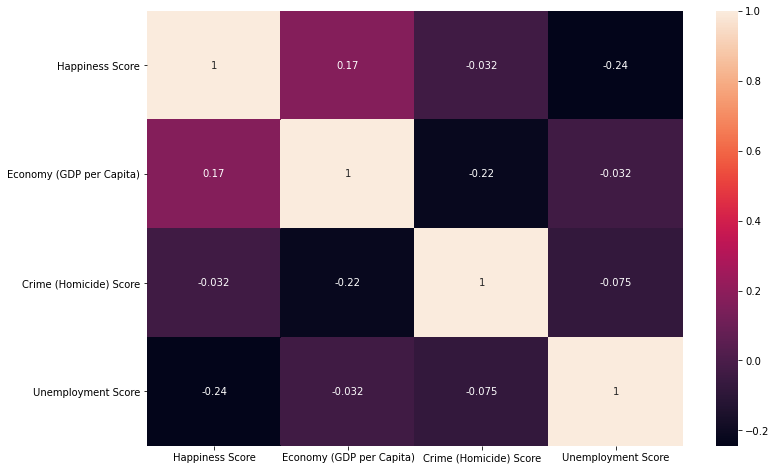

In [36]:
plt.figure(figsize=(12, 8))
sns.heatmap(data[['Happiness Score', 'Economy (GDP per Capita)', 'Crime (Homicide) Score', 'Unemployment Score']].corr(), annot=True)

**Histogram:** Looking for outliers by using boxplot is misleading for this kind of data, since looking for a mean, median, and related summary statistics only apply to distributions that have a single, central peak—that is, to unimodal distributions. Instead we will use histogram to get an overview of the data

**Trend line:** Since the data appears quite noisy it is difficult to establish if there's a trend in the data. We will therefore find a smooth curve that represents the noisy dataset. The method applied here is LOESS (or LOWESS), which is short for locally weighted regression. We use this since it is less responsive to local details in the dataset, which means that an 'outlier' does not affect the line as much.

Last commonly used tool at our disposal was **scatter plot** with trend lines. Since most of the data we've worked with was annual and could be treated as time series, the scatter plot allowed us to display the trends over time. At the same time, with the scatter plot and the trend line we could easily display how two features correlate with each other and if there is any connection.



![Scatter Plot](img/scatter.png)

# Discussion

The main challenge that we've faced while doing this report was that the data was not uniform. Since we've taken the data from different sources, they had different features, formats, and coverage. We've already mentioned the issue with getting the country codes for the datasets, however, much bigger issue was the fact that some datasets covered much smaller timespan than others, which was at times limiting when merged with the WHR dataset. Another issue with data was that some datasets simply didn't have data for many countries or had a lot of missing values. One of the datasets had over 90% missing values, for example. Such datasets were not viable to work with, and we had to discard a number of them, which is another limiting factor for our report. 

You can see a heatmap of missing values of one of the datasets we had to discard without any processing below (white represents missing values).


<AxesSubplot:>

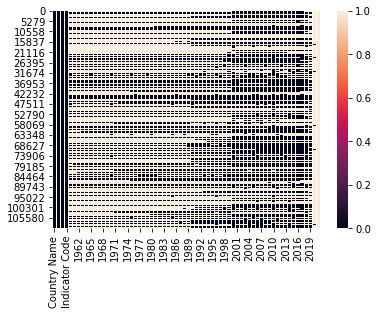

In [8]:
sns.heatmap(data.isna())

# Contributions

| Section | Responsible |
| --- | --- | 
| Introduction | Prashanna | 
| WHR data analysis | Johanne and Mark | 
| Suicide | Johanne | 
| Diet and GDP | Johanne | 
| Time spend | Johanne | 
| Income Inequality | Mark | 
| Crime Rate and Unemployment | Mark | 
| Human Development Index | Prashanna | 
| Legatum Prosperity Index data | Prashanna | 
| Feature Importance | Mark | 
| Website and Hosting | Prashanna | 
| Explainer Notebook | Mark | 